# To effectively build and manage an HR Management System in Python, having a well-structured HR dataset is crucial. The dataset should capture various aspects of HR information, ranging from basic employee details to more complex data like payroll, performance, and attendance records.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed

# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [ ]:
# import the file

Data = pd.read_csv('/content/HR_comma_sep.csv')

In [ ]:
Data.info() # information about data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [ ]:
#First I'd like to check for duplicate rows.

columns= Data.columns.tolist() # Make a list of name of columns
columns

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'left',
 'promotion_last_5years',
 'sales',
 'salary']

In [ ]:
Data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [ ]:
dupes = Data[Data.duplicated(keep=False)]
print('There are {} duplicates out of total {} rows.'.format(dupes.shape[0], Data.shape[0]))

There are 5346 duplicates out of total 14999 rows.


In [ ]:
#drop duplicates
Data = Data.drop_duplicates()
Data.shape
print('Without duplicates the dataset contains {} rows.'.format(Data.shape[0]))

#copy original dataset
hr = Data.copy(deep=True)

Without duplicates the dataset contains 11991 rows.


With duplicates removed, now I'd like to construct a dictionary that summarizes information needed for EDA. This dictionary should include the columns names, data type, classification of the data into categorical and continuous types, that relies on number of unique values for a given variable, range of values, as well as amount of missing values. To do so I'll write a function that can be used as a starting point for EDA of any other tidy dataset.


In [ ]:
#function that creates a generic dictionary for a given tidy data
def create_dict(df,ncol_cat=20):
    '''This function takes a data frame follewed by
    the threshold number of unique values in a single column
    to define categorical data type
    and returns a generic data frame dictionary'''

    df.columns=df.columns.str.lower()
    df_dict=pd.DataFrame(data=df.dtypes, columns=['type'])

    df_dict.index.name = 'column_name'
    df_dict['n_unique'] = df.nunique()

    type_info=[]
    range_info=[]
    for i in range(len(df_dict)):
        range_info.append([min(df[df_dict.index[i]]),max(df[df_dict.index[i]])])
        if (df_dict.n_unique.values[i] > ncol_cat) & (df_dict.type.values[i] != 'object'):
            type_info.append('continuous')
        else:
            type_info.append('categorical')
            #change data type to categorical to reduce memory usage
            df[df_dict.index[i]] = df[df_dict.index[i]].astype('category')

    df_dict['type_info'] = type_info
    df_dict['range_info'] = range_info
    df_dict['missing_values'] = df.isnull().sum()
    df_dict.sort_values(by = 'n_unique', inplace=True)

    reorder_cols=['type','type_info','n_unique','range_info','missing_values']
    df_dict = df_dict[reorder_cols]
    return df_dict

In [ ]:
hr_dict = create_dict(hr)
display(hr_dict)

#assign an ordered category manually
hr.salary = pd.Categorical(hr.salary,categories=['low','medium','high'],ordered=True)

,type,type_info,n_unique,range_info,missing_values
column_name,,,,,
work_accident,int64,categorical,2,"[0, 1]",0
left,int64,categorical,2,"[0, 1]",0
promotion_last_5years,int64,categorical,2,"[0, 1]",0
salary,object,categorical,3,"[high, medium]",0
number_project,int64,categorical,6,"[2, 7]",0
time_spend_company,int64,categorical,8,"[2, 10]",0
sales,object,categorical,10,"[IT, technical]",0
last_evaluation,float64,continuous,65,"[0.36, 1.0]",0
satisfaction_level,float64,continuous,92,"[0.09, 1.0]",0


**Univariate analysis:**

Having this summary on the dataset, I can proceed with univariate and bivariate analyses selecting the appropriate approaches for categorical and continuous data types. I'll start with univariate analysis and do the count plot for all categorical variables, as well as violin and box plot for each numeric variable to display the distribution of a given variable and depict the outliers, respectively. Do do it efficiantly I'd like to write a function that plots it for a given set of columns chosen or sorted according the their type.

In [ ]:
#function for a quick univariate analysis
def univar_plots(df,scols,sns_plottype,ncol_max=3):
    '''This function takes a data frame follewed by
    the list of selected columns and plot type of sns library
    appropriate for univariate analysis and returns a figure
    with the respective graphs for the selected data'''

    num_cols=len(scols)
    num_c = min([num_cols,ncol_max]); num_r = max([num_cols//ncol_max,1])

    if (num_r*num_c < num_cols)&(num_cols>ncol_max):
        num_r+=1

    fig, axes = plt.subplots(num_r, num_c, figsize=(min(16,num_c*4),ncol_max*num_r), sharex=False, sharey=False)

    i=0;j=0;k=0

    while (i < num_r):
        while (j < num_c) & (k < len(scols)):
            if num_r > 1:
                getattr(sns,sns_plottype)(y=scols[k], data=df, ax=axes[i,j])
            else:
                getattr(sns,sns_plottype)(y=scols[k], data=df, ax=axes[j])

            k += 1; j += 1
        j = 0; i += 1

    fig.tight_layout()

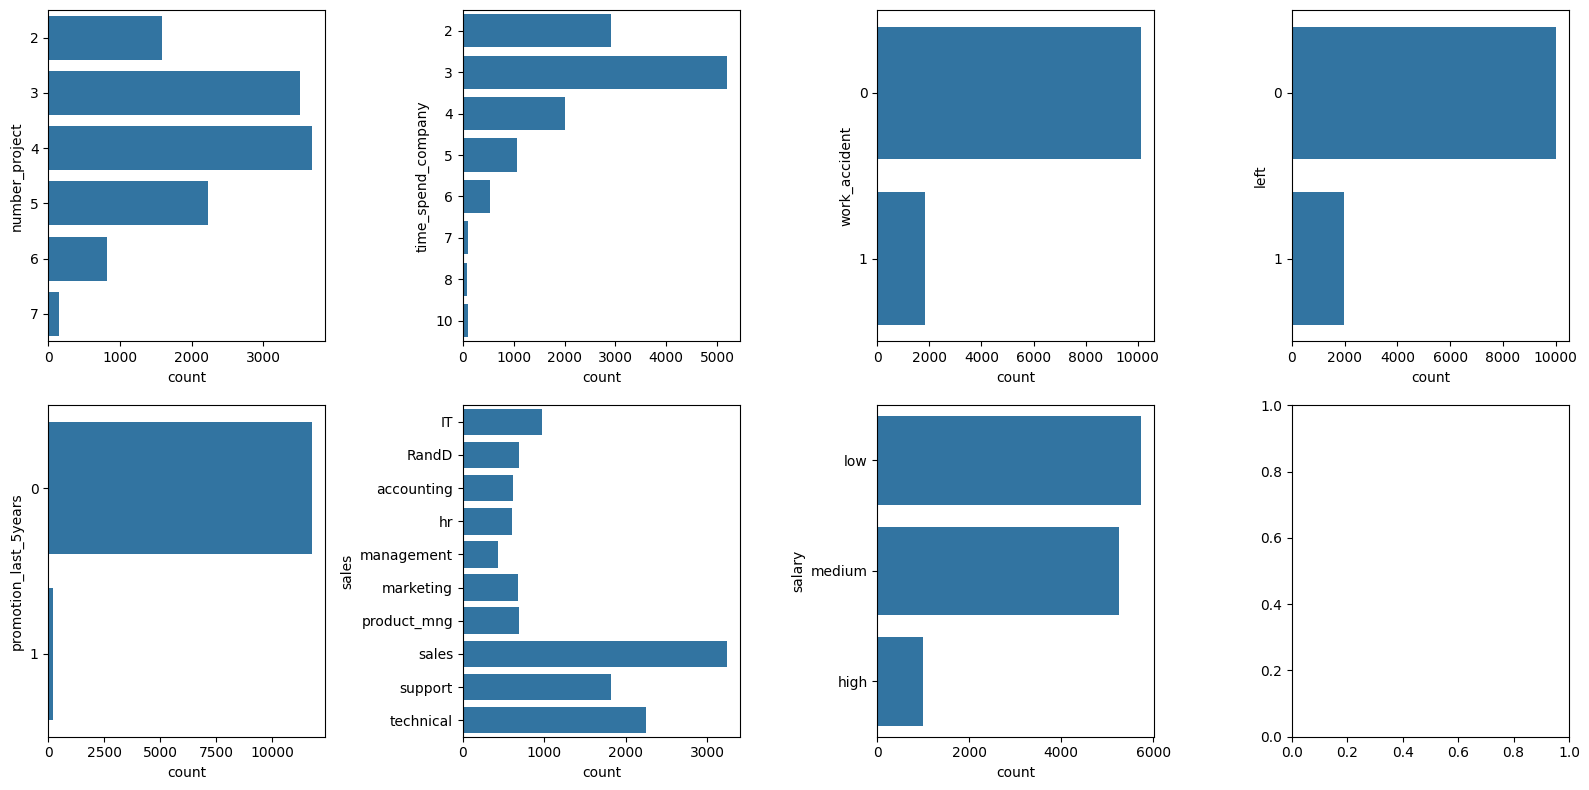

In [ ]:
#count plots for all categorical variables
univar_plots(hr,hr.columns[hr.dtypes == 'category'],sns_plottype='countplot',ncol_max=4)

To have a quantitative results, let's output the needed statistics:

In [ ]:
#statistics for categorical variables
hr_desc = hr.describe(include=['category']).drop(['count','freq'])
scols_count = hr.columns[hr.dtypes == 'category']
#add percentege of most and least frequent value
hr_desc.loc['top_perc',:] = [hr[col].value_counts(normalize=True).max().round(2) for col in scols_count]
hr_desc.loc['bottom',:] = [hr[col].value_counts(normalize=True).idxmin() for col in scols_count];
hr_desc.loc['bottom_perc',:] = [hr[col].value_counts(normalize=True).min().round(2) for col in scols_count]

hr_desc

column_name,number_project,time_spend_company,work_accident,left,promotion_last_5years,sales,salary
unique,6.00,8.00,2.00,2.00,2.00,10,3
top,4.00,3.00,0.00,0.00,0.00,sales,low
top_perc,0.31,0.43,0.85,0.83,0.98,0.27,0.48
bottom,7.00,8.00,1.00,1.00,1.00,management,high
bottom_perc,0.01,0.01,0.15,0.17,0.02,0.04,0.08


These graphs and the table with summary statistics show that:

1 Majority of employees (about 60%) had 3-4 projects, only 1% had 7 projects.

2 43% of employees spent 3 years in the company and only 1% spend 8 years.

3 Only 15% of employees had work accidents.

4 17% of employees left the company.

5 Only 2% were promoted within last 5 years (seems extremely low).

6 About third of the jobs are in sales and only 4% are in management.

7 About half of employees had low salary and only 8% had high salary.

Next, it would be interesting to see the overall distributions for all continuos data using the violin plot, as well as search for outliers using box plot.

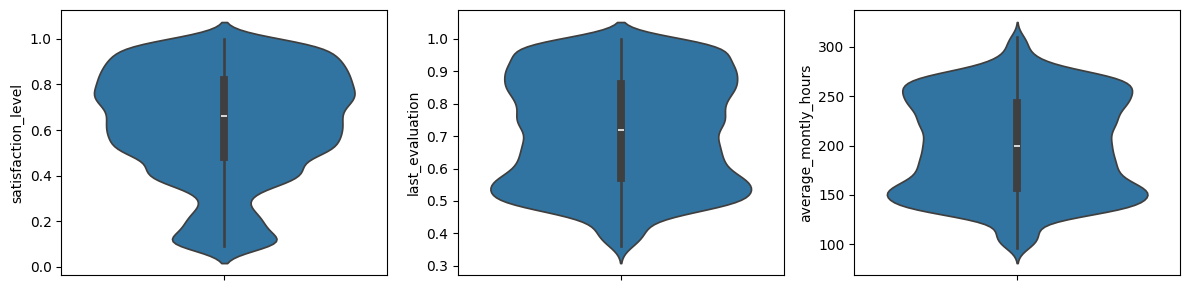

In [ ]:
#to check the distributions for numerical variables use the violinplot
scols_num = hr.select_dtypes(exclude=['category']).columns
univar_plots(hr,scols_num,sns_plottype='violinplot',ncol_max=3)

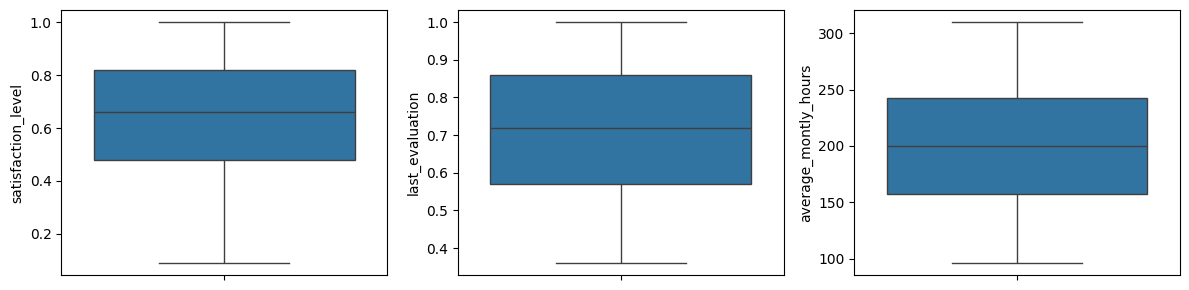

In [ ]:
#search for outliers via box plots
univar_plots(hr,scols_num,sns_plottype='boxplot',ncol_max=3)

In [ ]:
#statistics summary for the continuous variables
hr.describe(include=['number']).drop(['count']).T

,mean,std,min,25%,50%,75%,max
column_name,,,,,,,
satisfaction_level,0.629658,0.241070,0.09,0.48,0.66,0.82,1.0
last_evaluation,0.716683,0.168343,0.36,0.57,0.72,0.86,1.0
average_montly_hours,200.473522,48.727813,96.00,157.00,200.00,243.00,310.0


To summarize, most employees had more than 40% satisfaction level. Last evaluation and average montly hours have simular features: although mean for last evaluation/average hours is 0.72/200h, there are two noticeable peaks at 0.5/150h and 0.9/250h, respectively. There are no outliers according to the box plots.

**Multivariate analysis:**

Next, let's make multivariate plots to investigage relations between the available variables. I'll start with heatmap graphs for all categorical versus categorical data, using function that plots all combinations.





In [ ]:
#fuction for quick bivariate analysis of all categorical vs categorical data
def bivar_heatmap_plots(df,scols,ncol_max=3):
    '''This function takes a data frame follewed by
    the list of selected columns of categorical type
    and returns all combinations of heatmaps between
    them listing the percentage values of occurances on top'''

    num_cols=len(scols); Nplots=int(num_cols*(num_cols-1)/2)
    num_c = min([Nplots,ncol_max]); num_r = max([Nplots//ncol_max,1])

    if (num_r*num_c < Nplots)&(Nplots>ncol_max):
        num_r+=1

    fig, axes = plt.subplots(num_r, num_c, figsize=(min(16,num_c*6),ncol_max*num_r), sharex=False, sharey=False)

    ik=0;jk=0
    for i in range(num_cols):
        for j in range(i+1,num_cols):
            #calculate percentage (in %) of occurances
            col1_col2 = hr.groupby([scols[i],scols[j]]).size().unstack(scols[i]).div(hr.shape[0]).mul(100).round(1)
            cmap = sns.cubehelix_palette(10, start=jk, rot=0, dark=0.1, light=.9,as_cmap=True)

            if num_r > 1:
                sns.heatmap(col1_col2,annot=True,fmt=".1f",cmap=cmap,ax=axes[ik,jk])
            elif (num_r == 1)&(num_c == 1):
                sns.heatmap(col1_col2,annot=True,fmt=".1f",cmap=cmap);
            else:
                sns.heatmap(col1_col2,annot=True,fmt=".1f",cmap=cmap,ax=axes[jk])

            if jk < (num_c-1):
                jk += 1
            else:
                jk = 0; ik +=1
    fig.tight_layout()

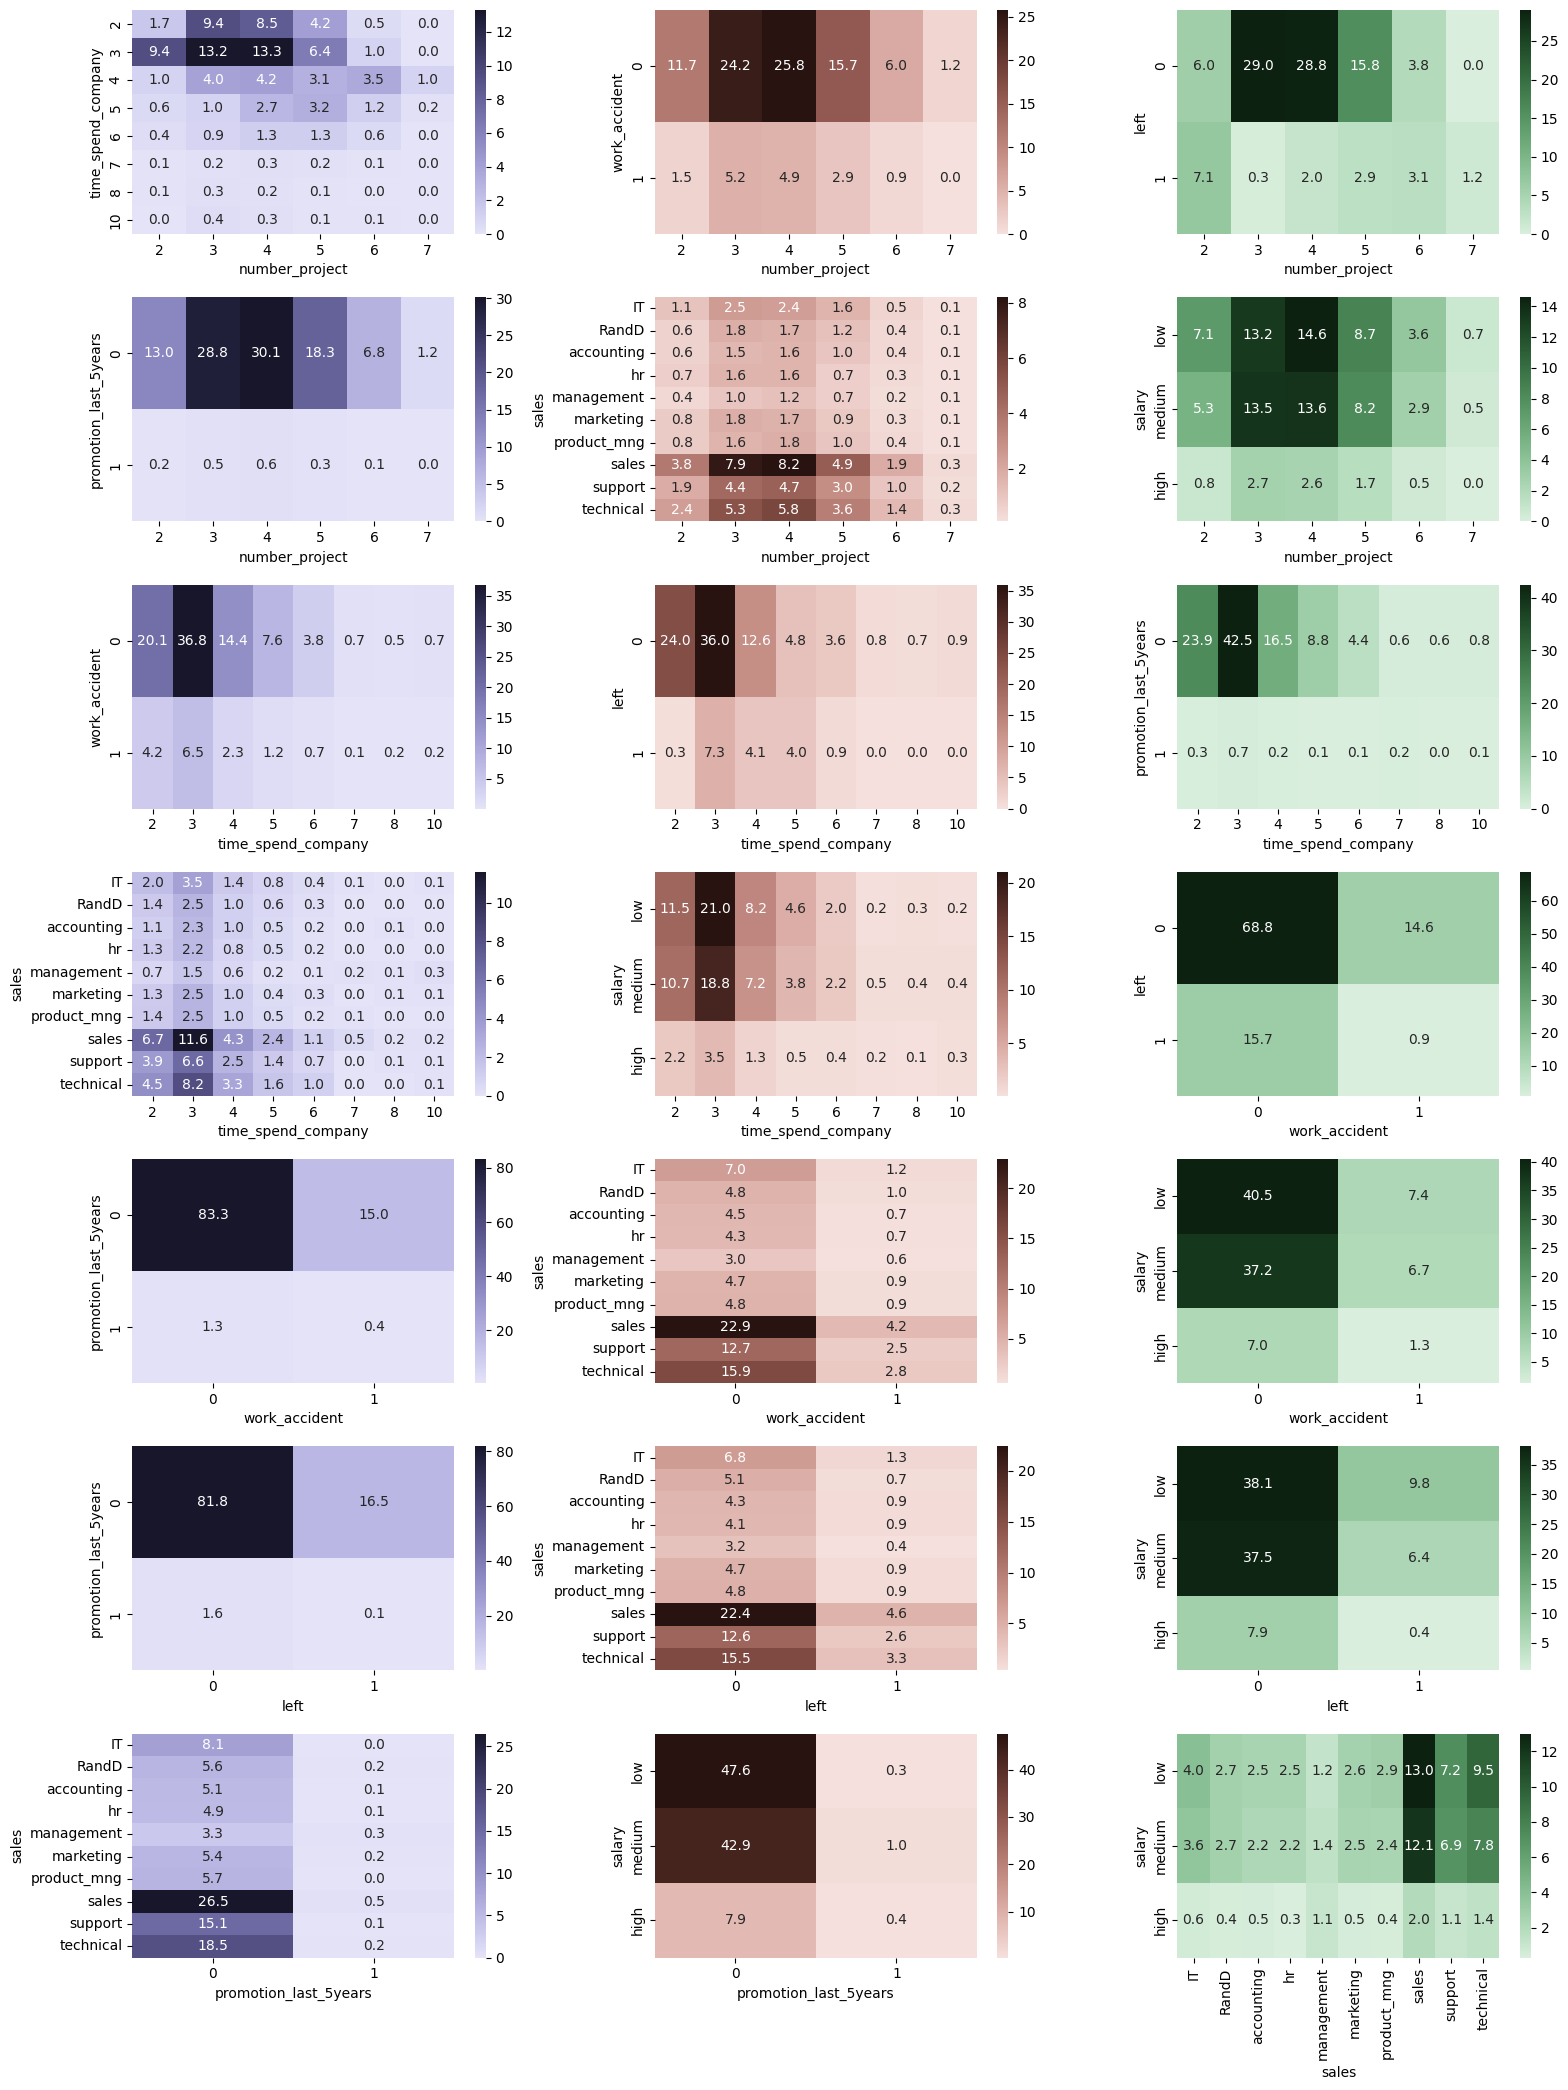

In [ ]:
#heatmap plots for all categorical variables
bivar_heatmap_plots(hr,hr.columns[hr.dtypes == 'category'],ncol_max=3)

In summary, according to the heatmap plot:

1. About half out of all employee with 3-4 projects spent 3 years in the company.
2. About 2/3 of employee with work accidents had 3-4 projects.
3. About 2/3 of employee with work accidents spent 2-3 years in the company.
4. Employees in sales with 3-4 projects prevail.
5. About half of employee had low-medium salary and 3-4 projects.
6. Most employee who left had either 2 or 5-6 projects.
7. About half employees who left spend 3 years in the company.
8. Majority of work accidents happend in sales, technical and support departments.
9. Salary does not affect the amount of work accidents.
10. About 60% employee who left had low salary and only 2.4% high salary.
11. Management department has most even distribution among the salary ranges, while low and medium salaries prevail (about 93%) in sales.



Moving to the analysis of categorical versus continuous data, number of projects and time spend in a company seems to be most important. Therefore, I'll plot a few heatmaps to analyze relation between them and contunuos variables.

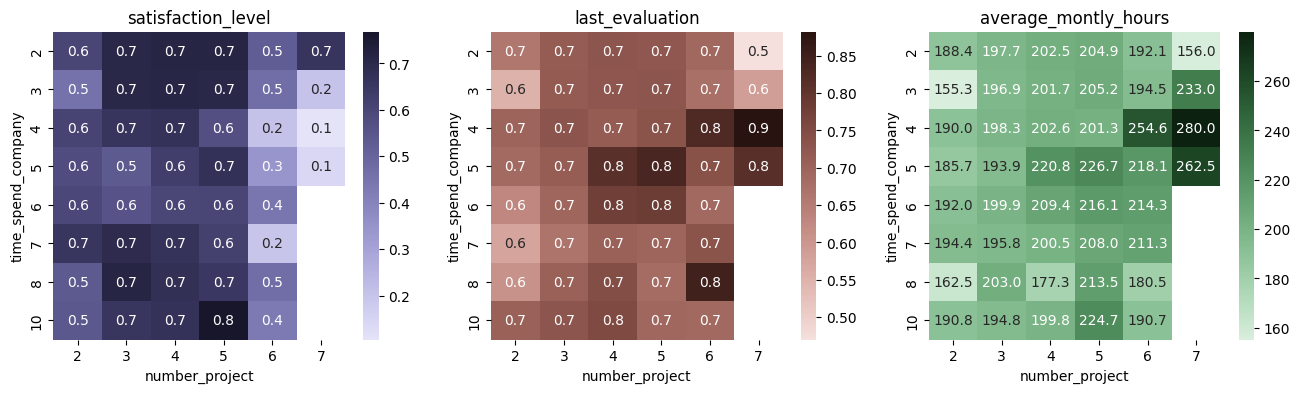

In [ ]:
col1='number_project';col2='time_spend_company';
scols_num = hr.select_dtypes(exclude=['category']).columns

fig, axes = plt.subplots(1, len(scols_num), figsize=(16,4), sharex=False, sharey=False)

for i in range(len(scols_num)):
    cc_heat = hr.groupby([col1,col2])[scols_num[i]].mean().unstack(col1)
    cmap = sns.cubehelix_palette(10, start=i, rot=0, dark=0.1, light=.9,as_cmap=True)
    sns.heatmap(cc_heat,annot=True,fmt=".1f",cmap=cmap,ax=axes[i])
    axes[i].set_title(scols_num[i])

1. Most employees are 0.7 (out of 1) satisfied, but the satisfaction level drasticly decreases for 6-7 projects becoming about 0.2.
2. Last evaluation is mostly 0.7, but it gets larger with number of projects increasing. Although it is quite low for employees who had 7 projects and spent 2 years at the company. Probably, this is because they worked less hours than average, according to the last right plot.
3. Average monthly hours overall increase with the number of projects, especially for more experienced.

Next, to explore the tendency for an employee to leave the company, I'll do pairplots for the continuous variables.



/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


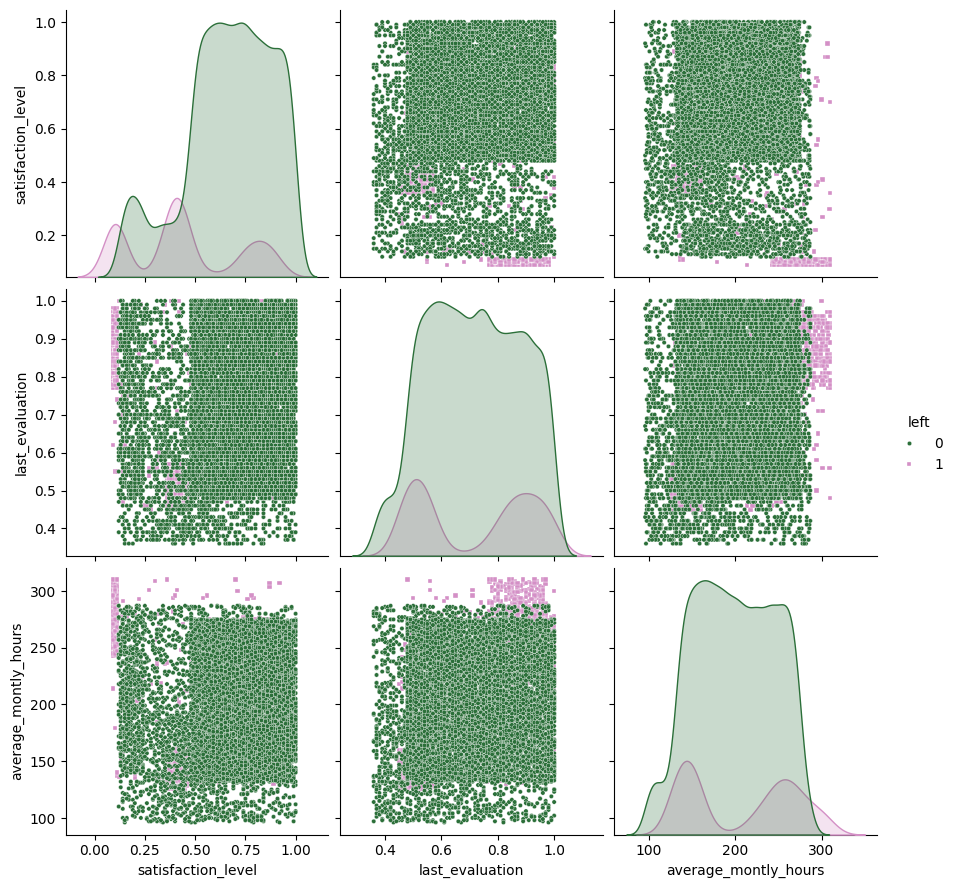

In [ ]:
scols_con = hr.select_dtypes(include=['number']).columns

sns.pairplot(hr,diag_kind='kde',vars=scols_con,hue='left',
                size=3,markers=["o", "s"],plot_kws={"s": 10},palette='cubehelix')

According to the graphs above, there are three distinct groups of employees who left.

1. Unhappy hard workers: worked noticeably higher than average, had best evaluations, were least satisfied. Probably left because of overload.
2. Unhappy poor workers: worked less than average, had bad evaluations, were less satisfied. Probably got fired.
3. Happy hard workers: worked higher than average, had higher than average evaluations, were higher than average satisfied. Probably found a better job and moved.

Having this information now I can sort the data to find the conditions for employee who left.

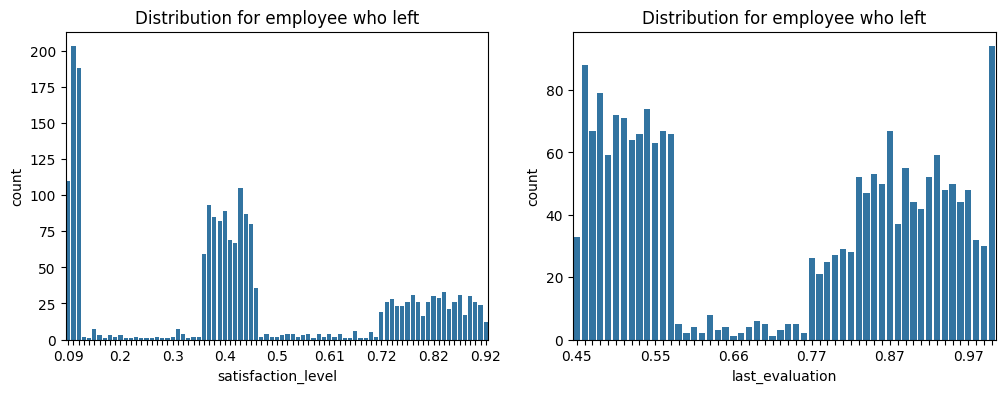

In [ ]:
#find boundaries for satisfaction level
sort1 = pd.DataFrame(hr.groupby('left')['satisfaction_level'].value_counts().loc[1])
sort1.columns = ['count_num']
sort1.reset_index(inplace=True)
sort1.sort_values(by=['satisfaction_level'],inplace=True)

#find boundaries for last evaluation
sort2 = pd.DataFrame(hr.groupby('left')['last_evaluation'].value_counts().loc[1])
sort2.columns = ['count_num']
sort2.reset_index(inplace=True)
sort2.sort_values(by=['last_evaluation'],inplace=True)

#visualize
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=False, sharey=False)

sns.countplot(x='satisfaction_level', data=Data[Data.left==1],ax=axes[0])
sns.countplot(x='last_evaluation', data=Data[Data.left==1],ax=axes[1])

for i in range(2):
    axes[i].set_title('Distribution for employee who left')

    for ind, label in enumerate(axes[i].get_xticklabels()):
        if ind % 10 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

In [ ]:
#there is an abrapt change for the following regions
#show numbers:
#print('Find boundaries based on satisfaction level: \n',sort1[sort1.count_num > 10])
sat1=[0.09,0.11];sat2=[0.36,0.46];sat3=[0.72,0.92]

#show numbers:
#print('Find boundaries based on last evaluation: \n',sort2[sort2.count_num > 10])
last1=[0.77,1.0];last2=[0.45,0.57];last3=[0.8,1.0]

In [ ]:
#set the conditions to indentify people who left
cond1 = (Data.satisfaction_level >= 0.09) & (Data.satisfaction_level <= 0.11) &\
        (Data.last_evaluation >= 0.77)
group1 = Data[cond1]
display(group1.left.value_counts(normalize=True))

cond2 = (Data.satisfaction_level >= 0.36) & (Data.satisfaction_level <= 0.46) &\
        (Data.last_evaluation >= 0.45) & (Data.last_evaluation <= 0.57)
group2 = Data[cond2]
display(group2.left.value_counts(normalize=True))

cond3 = (Data.satisfaction_level >= 0.72) & (Data.satisfaction_level <= 0.92) &\
        (Data.last_evaluation >= 0.8)
group3 = Data[cond3]
display(group3.left.value_counts(normalize=True))

left
1    1.0
Name: proportion, dtype: float64

left
1    0.896885
0    0.103115
Name: proportion, dtype: float64

left
0    0.713143
1    0.286857
Name: proportion, dtype: float64

First condition is perfect, second is good, but third one is very poor. Let's sort values based on the number of projects and time spend in a company.

In [ ]:
#refine 3rd condition
display(group3.groupby('number_project')['left'].value_counts())
display(group3.groupby('time_spend_company')['left'].value_counts())

number_project  left
2               0        50
                1         5
3               0       469
                1         4
4               0       480
                1       197
5               1       292
                0       222
6               0        27
                1         4
Name: count, dtype: int64

time_spend_company  left
2                   0       359
                    1         4
3                   0       609
                    1         5
4                   0       187
                    1         6
5                   1       387
                    0        38
6                   1       100
                    0        29
7                   0         7
8                   0        11
10                  0         8
Name: count, dtype: int64

Number of projects do not provide additional criteria, but it looks that employee who spend 5-6 years mostly left. Therefore, the third criteria can be significantly enchanced.

In [ ]:
cond3_mod = cond3 & ((Data.time_spend_company == 5) | (Data.time_spend_company == 6))
group3_mod = Data[cond3_mod]
display(group3_mod.left.value_counts(normalize=True))

left
1    0.879061
0    0.120939
Name: proportion, dtype: float64

Finally all these three conditions can be combined and used to predict whether the employee left the company.



In [ ]:
#combine all condition to build a criteria for employee to leave.
group_left= Data[cond1|cond2|cond3_mod]
group_left.left.value_counts(normalize=True)

left
1    0.917718
0    0.082282
Name: proportion, dtype: float64

Surprisenly, but such simple data analysis allows to build a rather good model (~92% accurate) to predict whether employee left or stayed in a company, based solely on satisfaction level, last evaluation and time spend in a company.

